# Random Forest Regression for price prediction

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [53]:
import pandas as pd
import numpy as np
import re
import math
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn import metrics
from sklearn.metrics import mean_squared_error

# Function for splitting training and test set
from sklearn.model_selection import train_test_split 

import warnings
warnings.filterwarnings("ignore")

This notebook performs regression analysis to predict heavy-equipment machine prices. The data is taken from the Blue Book for Bulldozers Kaggle Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This notebook is adapted from Jeremy Howard's fastai ML course. Some of the fastai dependencies are removed for performance comparisons and some of the fastai library functions are included here to make the notebook more self-contained. Such functions are attributed.


In [7]:
df_raw = pd.read_csv('Train.csv', parse_dates=["saledate"])

In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

To get an initial sense of the data, we can combine the provided data dictionary with some properties of the training data-set as below. 

In [18]:
data_dictionary = pd.read_excel('Data Dictionary.xlsx')
data_dictionary = data_dictionary.rename(columns={'Variable': 'feature', 'Description': 'description'})

to_join_df = pd.DataFrame(df_raw.dtypes,columns=['dtypes'])
to_join_df.reset_index(inplace=True)
to_join_df.rename(columns = {'index':'feature'}, inplace = True)
to_join_df["first_row"] = df_raw.loc[0].values
to_join_df["%data_missing"] = (df_raw.isnull().sum()/df_raw.shape[0]*100).values


data_preview = to_join_df.merge(data_dictionary, on ='feature',how ='left')
display_all(data_preview.style.set_properties(subset=['description'], **{'width': '1000px'}))

,feature,dtypes,first_row,%data_missing,description
0,SalesID,int64,1139246,0,unique identifier of a particular sale of a machine at auction
1,SalePrice,int64,66000,0,nan
2,MachineID,int64,999089,0,identifier for a particular machine; machines may have multiple sales
3,ModelID,int64,3157,0,identifier for a unique machine model (i.e. fiModelDesc)
4,datasource,int64,121,0,source of the sale record; some sources are more diligent about reporting attributes of the machine than others. Note that a particular datasource may report on multiple auctioneerIDs.
5,auctioneerID,float64,3,5.01988,"identifier of a particular auctioneer, i.e. company that sold the machine at auction. Not the same as datasource."
6,YearMade,int64,2004,0,year of manufacturer of the Machine
7,MachineHoursCurrentMeter,float64,68,64.4089,current usage of the machine in hours at time of sale (saledate); null or 0 means no hours have been reported for that sale
8,UsageBand,object,Low,82.6391,"value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel; e.g. 'Low' means this machine has less hours given it's lifespan relative to average of fiBaseModel."
9,saledate,datetime64[ns],2006-11-16 00:00:00,0,nan


In [24]:
def add_datepart(df, fldname, drop=True, time=False):
    """ Fastai library function - add_datepart converts a column of df from a datetime64 to 
      many columns containing the information from the date. This applies changes inplace.  
      
      Parameters:
      -----------
      df: A pandas data frame. df gain several new columns.
      fldname: A string that is the name of the date column you wish to expand.
      If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
      drop: If true then the original date column will be removed.
      time: If true time features: Hour, Minute, Second will be added.
      """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
 
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)


In [25]:
def train_cats(df):
    """Fastai library function - change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    """
    for n,c in df.items():
        if is_string_dtype(c): 
            df[n] = c.astype('category').cat.as_ordered()

In [26]:
def simple_proc_df(df, y_fld):

    """ excerpt from fastai library - proc_df takes a data frame df and splits off the response variable, and
     changes the df into an entirely numeric dataframe.
     """
    
    y = df[y_fld].values
    df.drop(y_fld, axis=1, inplace=True)
       
    na_dict = {}
    
    for n,c in df.items(): 
        na_dict = simple_fix_missing(df, c, n, na_dict)

    for n,c in df.items(): 
        simple_numericalize(df, c, n)
    
    df = pd.get_dummies(df, dummy_na=True)
    res = [df, y, na_dict]

    return res

In [27]:
def simple_fix_missing(df, col, name, na_dict):
    # excerpt from fastai library - note dummy indicator variables are created for numeric features with missing values
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


In [28]:
def simple_numericalize(df, col, name):
    #excerpt from fastai library
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1


In [29]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The metric used in this competition is RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [32]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [33]:
df_raw.shape

(401125, 53)

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. Expanding date-time into these additional fields allows trend/cyclical behavior to be captured as a function of time.

In [36]:
add_datepart(df_raw, 'saledate')

The categorical variables are currently stored as strings and must be encded numerically for processing with a random forest.`train_cats` converts strings to pandas categories.

In [39]:
train_cats(df_raw)

Replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [40]:
df, y, nas = simple_proc_df(df_raw, 'SalePrice')

df_raw is now prepared for regression analysis. Save a checkpoint.

In [ ]:
df_raw.to_csv('bulldozers_csv')

In [44]:
#Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1234)

# Print number of observations in X_train, X_test, y_train, and y_test
print( len(X_train), len(X_test), len(y_train), len(y_test))


320900 80225 320900 80225


In [45]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    print(res)

Now fit a default RandomForestRegressor and prints the scores.
The 4 values are respectively: 1)RMSE of the predicted SalePrice in the training set, 2) RMSE of the predicted SalePrice in the test set, 3) R^2 or proportion of variance in the training set accounted for by our model and 4) R^2 for the test set.
The predicted SalePrice is computed as the mean predicted regression targets of the trees in the forest.

In [48]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2min 37s, sys: 633 ms, total: 2min 38s
Wall time: 53.1 s
[0.09182606814871888, 0.2172744654862039, 0.9824889766010101, 0.9015338154733157]


Because this dataset was used in a (now closed) kaggle competion, the scores above can be compared with the leaderboard for this competition:
https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard

An RMSLE of 0.217 would have been sufficient to win this competition at the time it was run.
Of course, the test set used here is not the same as that used in the original competion, plus I have selected the test data as a random subset of the overall training data provided. In the original competition the test set did not chronologically overlap with the training set. 
The result is that a better RMSLE score is to be expected. Nonethless the standard out-of-the-box performance is impressive.This is testament to the power of sklearn library and the default RandomForestRegresor implementation.


### Hyper-parameter optimizations

The following optimizations are suggested in fastai ML lecture 2. A common optimization is an ensemble method which creates a bag of uncorrelated random forests and averages over their individual predictions.

In [49]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)


[0.07976952051575029, 0.20845534272613675, 0.9867854154589961, 0.9093650309969359]


To show the impact of averaging across multiple loosely correlated trees we can use the following plot to show how R^2 varies with the number of trees we average across.

In [50]:
preds = np.stack([t.predict(X_test) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_test[0]

(array([ 9.76995616,  9.74096862,  9.92818017,  9.74096862, 10.08580911,
         9.85219426,  9.90348755, 10.14643373,  9.87816974, 10.1266311 ,
        10.02127059,  9.74096862,  9.71111566,  9.85219426,  9.90348755,
         9.87816974,  9.90348755,  9.82552601,  9.82552601,  9.82552601,
         9.95227772,  9.71111566,  9.82552601, 10.1266311 ,  9.87816974,
         9.680344  ,  9.90348755,  9.76995616,  9.82552601,  9.82552601,
         9.87816974,  9.74096862,  9.90348755,  9.90348755,  9.82552601,
         9.76995616,  9.74096862,  9.95227772,  9.82552601,  9.95227772]),
 9.866281919144786,
 9.740968623038354)

In [51]:
preds.shape

(40, 80225)

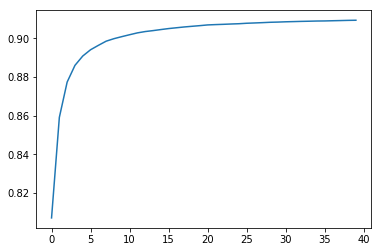

In [54]:
plt.plot([metrics.r2_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

The shape of this curve suggests that adding more than 30 trees does not lead to much improvement.

Specifying 'min_samples_leaf'-the minium number of rows in every leaf node - allows us to reduce over-fitting.

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [55]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11662984129040965, 0.20952192605906617, 0.9717512705095239, 0.9084351718104572]


Another hyper-parameter to specify is `max_features` - the proportion of features to randomly select from at each split.

In [57]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12070647151089312, 0.2053613274614157, 0.9697419692282464, 0.9120355776124289]


At this point we can see that we have reduced over-fitting and have a test set RMSLE and R^2 of 0.205 and 0.912 respectively - improving on our earlier and already strong default RandomForestRegressor scores. 